In [1]:
import numpy as np
from matplotlib import pyplot as pp
%matplotlib inline

In [2]:
import os
from os.path import join

In [3]:
%autoreload 2

In [4]:
from utils import Frame
def load(folder=None, model="ensemble-pairs"):
    path = os.path.join('trained_models', folder)
    setnames = ['tr', 'va', 'te', 'de', 'special']
    sets = dict((k,Frame(np.load(os.path.join(path,"%s.npz"%k))))
                for k in setnames
                if os.path.exists(os.path.join(path,"%s.npz"%k)))
    prs = dict((k,Frame(np.load(os.path.join(path,model,"pr_%s.npz"%k))))
                for k in setnames
                if os.path.exists(os.path.join(path,model,"pr_%s.npz"%k)))
    trms = Frame(**np.load(os.path.join(path,"tr_mean_std.npz")))
    return trms, sets, prs
trms, sets, prs = load(folder='benzene-k', model="dummy-const")
print(sets.keys(), prs.keys())
print(prs['te'].keys())

dict_keys(['te', 'va', 'de', 'tr']) dict_keys(['te', 'va', 'de', 'tr'])
dict_keys(['T', 'Y', 'maxY', 'index', 'minY'])


In [5]:
len(sets['te']), len(sets['de']), len(sets['va'])

(447984, 10000, 10000)

In [6]:
# prepare cache for cachedshim
data = Frame((k, np.concatenate([prs[sid][k] for sid in prs.keys()])) for k in prs['te'].keys())
np.savez(join('tmp','cachedshim'), **data)

In [7]:
# quick check if has been joined correctly
len(np.unique(data['index'])) == len(data)

True

In [8]:
from networks.shims import params, DTNNShim, CachedShim
%autoreload 2
params['tr_mean_std'] = trms
params['mu_max'] = 10
params['point'] = sets['tr'][0]

net = CachedShim()
for name,d in sets.items():
    pr = net.predict(d)
    print(((d['T']-pr['Y'])**2).mean()**0.5, name)

0.0583819138947 te
0.0586156569954 va
0.0584874669181 de
0.0510871474813 tr


In [9]:
from utils import Timer

In [64]:
va10k = te[np.random.choice(np.arange(len(te)), size=10000, replace=False)]
print(len(va10k))

10000


In [12]:
sid = 'tr'
k_range = general_sweep = (np.linspace(2/len(sets[sid]), 0.5, 50)*len(sets[sid])).astype(int)
print(general_sweep)

[    2   512  1022  1532  2042  2552  3062  3573  4083  4593  5103  5613
  6123  6634  7144  7654  8164  8674  9184  9695 10205 10715 11225 11735
 12245 12756 13266 13776 14286 14796 15306 15817 16327 16837 17347 17857
 18367 18878 19388 19898 20408 20918 21428 21939 22449 22959 23469 23979
 24489 25000]


In [13]:
nmax = 200
k_range = (np.linspace(2/nmax, 1.0, 50)*nmax).astype(int)
k_range

array([  2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42,  46,  50,
        54,  58,  62,  66,  70,  74,  78,  82,  86,  90,  94,  98, 103,
       107, 111, 115, 119, 123, 127, 131, 135, 139, 143, 147, 151, 155,
       159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 200])

In [14]:
from scores import pearsonr
from uncertainty.knn import KNNUncertainty

# k_range = np.arange(5,200,5)
# k_range = np.arange(2,20,1)
# k_range = np.arange(2,200,1)
# k_range = general_sweep
# k_range = np.linspace(0.02,0.5,25)
q_range = [None, 0.9] # coverage
s_range = [sid]
y_range = ["", "Y"]
methods = [
    'avgdist',
#     'dev', # knn vs NN
#     'label_var', # confive
#     'label_std', # confive**0.5
#     'mse', # confine
]

Ts = dict(
    (sets, dict(
        (y, dict(
            (m, dict(
                (q,[])
                for q in q_range))
            for m in methods))
        for y in y_range))
    for sets in s_range)
Ns = {'tr':len(sets['tr']), 'va':len(sets['va']), 'tr va': len(sets['va'])+len(sets['tr'])}
clock = Timer(len(k_range)*len(s_range)*len(q_range)*len(y_range)*len(methods))
for s in s_range:
    for y in y_range:
        est = KNNUncertainty(CachedShim, sets=s, keys=y, n_jobs=20, silent=True)
        est.fit(sets['tr'], sets['va'])
        for k in k_range[::-1]:
            for m in methods:
                for q in q_range:
                    est.method = m
                    est.neighbors = k
                    prY, minY, maxY = est.predict(sets['de'], coverage=q)
                    prU = (maxY - minY)/2
                    c,pvalue = pearsonr(sets['de']['T'], prY, prU)
                    Ts[s][y][m][q] += [[k, c, pvalue]]
                    print(clock.tick(), k, '                              ', end="\r")

/home/robert/CPU/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/robert/CPU/lib/python3.5/site-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


/home/robert/CPU/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/robert/CPU/lib/python3.5/site-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [16]:
import pickle
with open('results/k-tr-avgdist2-Ts.pkl', "wb") as f: pickle.dump(Ts,f)

### timing

In [160]:
est = KNNUncertainty(CachedShim, sets="tr", neighbors=0.05, keys="", n_jobs=8, silent=True)
est.method = 'label_std'

In [161]:
def run():
    est.fit(tr, va)
    prY, minY, maxY = est.predict(sample, coverage=None)
%timeit run()

16 s ± 1.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### plotting

In [27]:
translate = {
    "tr": "(Training Set)",
    "va": "(Validation Set)",
    "absdev": "Absolute Deviation",
    "dev": "Deviation",
    "mae": "Mean Absolute Error",
    "mse": "Mean Square Error",
    "rmse": "Root Mean Square Error",
    "biased_std": "Biased Std.",
    "avgdist": "Average Distance",
    "label_std": "Label Std.",
    "label_var": "Label Variance",
}

In [17]:
for s in Ts.keys():
    for m in Ts[s][''].keys():
        for y in y_range:
            for q in q_range:
                T = np.array(Ts[s][y][m][q])
                imax = np.nanargmax(np.abs(T[:,1]))
                rmax = T[imax,1]
                k = T[imax,0]
#                 k = int(np.round(k*len(sample)))
                k = int(k)
                print("{: 6.4f} {:>15s} {}{} {:4d}".format(
                    rmax,
                    m,
                    'q' if q is not None else ' ',
                    'y' if y!='' else ' ',
                    k
                ))

 0.2165         avgdist      34
 0.0949         avgdist q    30
 0.2260         avgdist  y   34
 0.1062         avgdist qy   34


In [40]:
# merge all runs into single plots
import re
dicts = []
for filename in os.listdir('results'):
    if re.match(r'k-va-.*\.pkl', filename):
        print(filename)
        dicts += [pickle.load(open('results/%s'%filename, 'rb'))]

k-va-ints-Ts.pkl
k-va-Ts.pkl


In [41]:
def join(a, b):
    result = dict()
    keys = list(set(a.keys()) | set(b.keys()))
    print(keys, 'keys')
    for k in keys:
        A,B = (a,b) if k in a.keys() else (b,a)
        if k in B.keys():
            if isinstance(A[k], dict) and isinstance(B[k], dict):
                result[k] = join(A[k], B[k])
            elif isinstance(A[k], list) and isinstance(B[k], list):
                result[k] = A[k] + B[k]
        else:
            result[k] = A[k]
    return result
Ts = dict()
for t in dicts:
    Ts = join(Ts,t)

['va'] keys
['va'] keys
['', 'Y'] keys
['avgdist', 'mse', 'label_var', 'dev', 'label_std'] keys
[0.9, None] keys
[0.9, None] keys
['avgdist', 'mse', 'label_var', 'dev', 'label_std'] keys
[0.9, None] keys
[0.9, None] keys


In [39]:
with open("results/k-va-Ts.pkl", "rb") as f: Ts = pickle.load(f)

In [60]:
%matplotlib inline

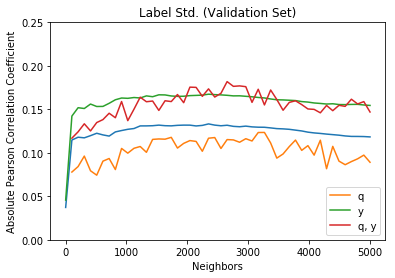

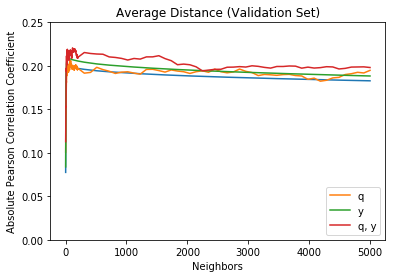

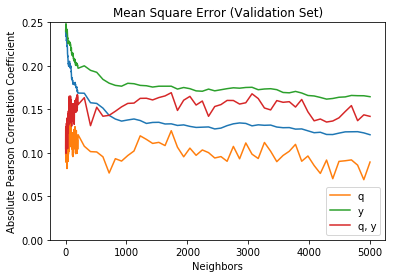

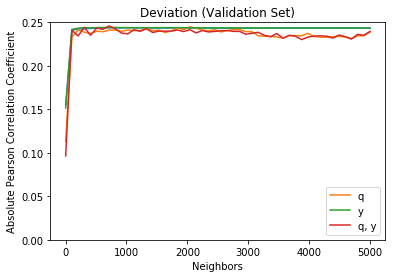

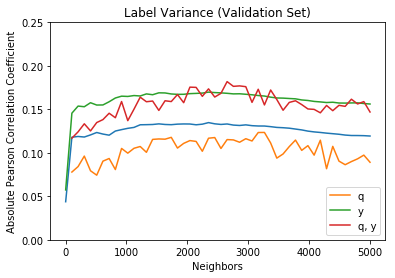

In [43]:
for s in Ts.keys():
    for m in Ts[s][''].keys():
        for y in y_range:
            for q in q_range:
                T = np.array(Ts[s][y][m][q])
                T = T[T[:,0].argsort()]
                T = T[T[:,0]<=10000]
                label = []
                if q is not None: label += ["q"]
                if y != "": label += ["y"]
                pp.plot(T[:,0], np.abs(T[:,1]), label=", ".join(label))
        pp.ylim([0, 0.25])
        pp.ylabel("Absolute Pearson Correlation Coefficient")
        pp.xlabel("Neighbors".format(Ns[s]))
        pp.legend(loc='lower right')
        pp.title("{} {}".format(translate[m], translate[s]))
        os.makedirs("figs/k/{}-merged".format(s), exist_ok=True)
        pp.savefig("figs/k/{}-merged/{}.jpg".format(s,m), dpi=300)
        pp.savefig("figs/k/{}-merged/{}.pdf".format(s,m), dpi=300)
        pp.show()

In [17]:
for i in range(100):print()